# 06.01.e Optimize 5: Only Seven Vars
 
Goal: identify the factors that most contribute to SLAFail

Tuning Adjustments: Focus on finding the most predictive set of predictor variables

Read Prepared Data  ->  Split Data  -> Develop Pipeline  ->  Evaluate  



In [29]:
# create dictionary to store information about the pipeline and results for later reporting and review
PipeLineMetadata = { "Name" : "Optimize Round 5: Only Seven Vars" }

In [30]:
outFileName = "data/06.00.e Only Seven Vars.pkl"

In [31]:

# Load libraries
import pandas as pd
import numpy as np
import pickle
pd.options.display.float_format = '{:.7f}'.format

# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.compose import make_column_transformer
import category_encoders as ce
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

## Read Prepared Data

In [42]:
df = pd.read_csv("data/05.00 Incident Data.csv")
print("df.shape: " + str(df.shape))
print("df.columns: " + str(df.columns))
print("df.dtypes: \n" + str(df.dtypes))

df.shape: (35208, 10)
df.columns: Index(['Service_Component_WBS_aff', 'Urgency', 'KM_number',
       'Count_Related_Interactions', 'Count_Related_Incidents',
       'Count_Related_Changes', 'SLAFail', 'Open_Time_HourOfDay',
       'Open_Time_DayOfWeek', 'CI_TypeSubType_aff'],
      dtype='object')
df.dtypes: 
Service_Component_WBS_aff      object
Urgency                        object
KM_number                      object
Count_Related_Interactions    float64
Count_Related_Incidents       float64
Count_Related_Changes         float64
SLAFail                         int64
Open_Time_HourOfDay             int64
Open_Time_DayOfWeek            object
CI_TypeSubType_aff             object
dtype: object


#### Set X and y

In [43]:
y = df.SLAFail
y.shape

(35208,)

In [44]:
X = df.drop(['SLAFail'], axis='columns')
X.shape

(35208, 9)

Set `Open_Time_HourOfDay` for recognition as a Categorical variable

In [45]:
X.Open_Time_HourOfDay = X.Open_Time_HourOfDay.astype('object')
X.dtypes

Service_Component_WBS_aff      object
Urgency                        object
KM_number                      object
Count_Related_Interactions    float64
Count_Related_Incidents       float64
Count_Related_Changes         float64
Open_Time_HourOfDay            object
Open_Time_DayOfWeek            object
CI_TypeSubType_aff             object
dtype: object

Drop 'insignificant' variable

In [46]:
X = X.drop(['Open_Time_DayOfWeek'], axis='columns')
X.columns

Index(['Service_Component_WBS_aff', 'Urgency', 'KM_number',
       'Count_Related_Interactions', 'Count_Related_Incidents',
       'Count_Related_Changes', 'Open_Time_HourOfDay', 'CI_TypeSubType_aff'],
      dtype='object')

Create a list of numeric variable column names

In [48]:
numericVars = X.select_dtypes(include=['float64']).columns
numericVars

Index(['Count_Related_Interactions', 'Count_Related_Incidents',
       'Count_Related_Changes'],
      dtype='object')

Create a list of categorical variables

In [49]:
categoricalVars = X.select_dtypes(include=['object']).columns
categoricalVars

Index(['Service_Component_WBS_aff', 'Urgency', 'KM_number',
       'Open_Time_HourOfDay', 'CI_TypeSubType_aff'],
      dtype='object')

## Split Data

Create Training and Testing Data Sets


In [50]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)


In [51]:
print(X_train.shape)
print(X_train.columns)

(24645, 8)
Index(['Service_Component_WBS_aff', 'Urgency', 'KM_number',
       'Count_Related_Interactions', 'Count_Related_Incidents',
       'Count_Related_Changes', 'Open_Time_HourOfDay', 'CI_TypeSubType_aff'],
      dtype='object')


## Develop Pipeline


### Encode Variables

Numeric and categorical variables require different treatment 

Set up column transformer for scaling numeric variables and encoding categorical variables



In [52]:
column_trans = make_column_transformer(
    (ce.WOEEncoder(), categoricalVars),
    (StandardScaler(), numericVars),
    remainder='passthrough')

### Specify Classifier (Logistic Regression)

In [53]:
classifier = LogisticRegression(solver="lbfgs")

### Compose Pipeline

In [54]:
pipe = Pipeline(steps=[('column_trans', column_trans), 
                        ('classifier', classifier)
                        ])

In [55]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('column_trans',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('woeencoder',
                                                  WOEEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             random_state=None,
                                                             randomized=False,
                                                             regularization=1.0,
                                                             return_df=True,
                                                

In [56]:
pipe.named_steps.classifier

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Evaluate with Testing Data

Get predicted classification and predicted probabilities based on the model

In [57]:
y_pred_class = pipe.predict(X_test)


In [58]:
y_pred_prob = pipe.predict_proba(X_test)[:,1]



In [59]:
print(metrics.classification_report(y_test, y_pred_class))

precision    recall  f1-score   support

           0       0.77      0.88      0.82      7445
           1       0.57      0.37      0.45      3118

    accuracy                           0.73     10563
   macro avg       0.67      0.63      0.64     10563
weighted avg       0.71      0.73      0.71     10563



Look at the resulting confusion matrix

Save True Positive (TP), True Negative (TN), False Positive(FP), and False Negative (FN) values

In [60]:
confusion = metrics.confusion_matrix(y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print(confusion)
print("TN: %d \t FP: %d \nFN: %d \t TP: %d " % (TN, FP, FN, TP))

[[6572  873]
 [1960 1158]]
TN: 6572 	 FP: 873 
FN: 1960 	 TP: 1158 


Capture resulting AUC

In [61]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
metrics.roc_auc_score(y_test, y_pred_prob)

0.766148419605652

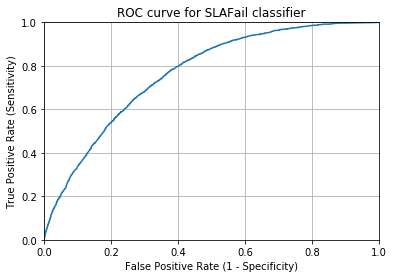

In [63]:
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for SLAFail classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

## Save Details and Performance Measures for Comparison to other Models


In [64]:
pipe.named_steps

{'column_trans': ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
                   transformer_weights=None,
                   transformers=[('woeencoder',
                                  WOEEncoder(cols=None, drop_invariant=False,
                                             handle_missing='value',
                                             handle_unknown='value',
                                             random_state=None, randomized=False,
                                             regularization=1.0, return_df=True,
                                             sigma=0.05, verbose=0),
                                  Index(['Service_Component_WBS_aff', 'Urgency', 'KM_number',
        'Open_Time_HourOfDay', 'CI_TypeSubType_aff'],
       dtype='object')),
                                 ('standardscaler',
                                  StandardScaler(copy=True, with_mean=True,
                                                 with_std=True)

In [67]:
PipeLineMetadata['Column Transforms'] = pipe.named_steps.column_trans.transformers
PipeLineMetadata['Classifier'] = pipe.named_steps.classifier
PipeLineMetadata

{'Name': 'Optimize Round 5: Only Seven Vars',
 'Column Transforms': [('woeencoder',
   WOEEncoder(cols=None, drop_invariant=False, handle_missing='value',
              handle_unknown='value', random_state=None, randomized=False,
              regularization=1.0, return_df=True, sigma=0.05, verbose=0),
   Index(['Service_Component_WBS_aff', 'Urgency', 'KM_number',
          'Open_Time_HourOfDay', 'CI_TypeSubType_aff'],
         dtype='object')),
  ('standardscaler',
   StandardScaler(copy=True, with_mean=True, with_std=True),
   Index(['Count_Related_Interactions', 'Count_Related_Incidents',
          'Count_Related_Changes'],
         dtype='object'))],
 'Classifier': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start

In [68]:
PipeLineMetadata['Classifier - Intercept'] = pipe.named_steps.classifier.intercept_[0]
PipeLineMetadata['Classifier - Coefficients'] = pipe.named_steps.classifier.coef_[0]

In [69]:
PipeLineMetadata

{'Name': 'Optimize Round 5: Only Seven Vars',
 'Column Transforms': [('woeencoder',
   WOEEncoder(cols=None, drop_invariant=False, handle_missing='value',
              handle_unknown='value', random_state=None, randomized=False,
              regularization=1.0, return_df=True, sigma=0.05, verbose=0),
   Index(['Service_Component_WBS_aff', 'Urgency', 'KM_number',
          'Open_Time_HourOfDay', 'CI_TypeSubType_aff'],
         dtype='object')),
  ('standardscaler',
   StandardScaler(copy=True, with_mean=True, with_std=True),
   Index(['Count_Related_Interactions', 'Count_Related_Incidents',
          'Count_Related_Changes'],
         dtype='object'))],
 'Classifier': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start

Capture a few classification metrics:
* Classification Accuracy: Overall, how often is the classifier correct?
* Classification Error: Overall, how often is the classifier incorrect?
* True Positive Rate  (Recall, Sensitivity): When the actual value is positive, how often is the prediction correct?
* True Negative Rate (Specificity): When the actual value is negative, how often is the prediction correct?
* False Positive Rate: When the actual value is negative, how often is the prediction incorrect?
* Precision: When a positive value is predicted, how often is the prediction correct?


In [70]:
PipeLineMetadata['Metrics - Classification Report'] = metrics.classification_report(y_test, y_pred_class)
PipeLineMetadata['Metrics - Confusion Matrix'] =metrics.confusion_matrix(y_test, y_pred_class)
PipeLineMetadata['Metrics - Confusion Matrix Classification Accuracy'] = metrics.accuracy_score(y_test,y_pred_class) 
PipeLineMetadata['Metrics - Confusion Matrix Classification Error'] = 1- metrics.accuracy_score(y_test,y_pred_class)
PipeLineMetadata['Metrics - Confusion Matrix True Positive Rate'] = metrics.recall_score(y_test, y_pred_class) 
PipeLineMetadata['Metrics - Confusion Matrix True Negative Rate'] =  TN / float(TN + FP)
PipeLineMetadata['Metrics - Confusion Matrix False Positive Rate'] =  FP / float(TN + FP)
PipeLineMetadata['Metrics - Confusion Matrix Precision'] = metrics.precision_score(y_test,y_pred_class)


In [71]:
PipeLineMetadata['Metrics - AUC'] = metrics.roc_auc_score(y_test, y_pred_prob)

In [72]:
PipeLineMetadata['Metrics - ROC Curve fpr array'] = fpr
PipeLineMetadata['Metrics - ROC Curve tpr array'] = tpr

In [73]:
PipeLineMetadata

{'Name': 'Optimize Round 5: Only Seven Vars',
 'Column Transforms': [('woeencoder',
   WOEEncoder(cols=None, drop_invariant=False, handle_missing='value',
              handle_unknown='value', random_state=None, randomized=False,
              regularization=1.0, return_df=True, sigma=0.05, verbose=0),
   Index(['Service_Component_WBS_aff', 'Urgency', 'KM_number',
          'Open_Time_HourOfDay', 'CI_TypeSubType_aff'],
         dtype='object')),
  ('standardscaler',
   StandardScaler(copy=True, with_mean=True, with_std=True),
   Index(['Count_Related_Interactions', 'Count_Related_Incidents',
          'Count_Related_Changes'],
         dtype='object'))],
 'Classifier': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start

In [74]:
with open(outFileName,'wb') as fo:
    pickle.dump(PipeLineMetadata, fo)